## Robust Shadow Tomography

Related papers
 [Chen et al PRX Q 2021](https://doi.org/10.1103/PRXQuantum.2.030348)
 [Koh et al Quantum 2022](https://quantum-journal.org/papers/q-2022-08-16-776/)
 [Vitale et al](http://arxiv.org/abs/2307.16882)

In [18]:
using Revise
using ITensors,ITensorMPS
using RandomMeas
using ProgressMeter

In [24]:
#Perform RM in the first experiment
N = 6
ξ = siteinds("Qubit", N)

p,dp = 0.15,0.02
p_vec = [max(0, min(p + dp * randn(), 1)) for i in 1:N]
G = 1 .-p_vec/2


states = ["Dn" for n in 1:N]
ψ0  = MPS(ComplexF64,ξ,states)
ρ0 = outer(ψ0',ψ0)
ρ0n = Apply_depo_channel(ρ0,p_vec)


depth = 2
circuit = RandomCircuit(ξ,depth)
ρ = apply(circuit,ρ0,apply_dag=true)
#runcircuit(ρ0,circuit)
ρn = Apply_depo_channel(ρ,p_vec)
#ρ = runcircuit(circuit;noise = noisemodel);
println("state prepared in the `experiment' 1 ")
#RM on a calibration state


nu=1000 #Number of random unitaries
NM=1000 #Number of projective measurements per unitary

state prepared in the `experiment' 1 


1000

In [25]:
#Calibration experiment
Gs = zeros(Float64,N)
@showprogress dt=1 for r in 1:nu
        u = get_rotations(ξ,1) #Haar rotations in A
        data = get_RandomMeas(ρ0n,u,NM)
        σu = apply(u,ρ0,apply_dag=true)
        #σu = rotate(ρ0,u)
        for i in 1:N
            P = get_Born(data[:,i:i],ξ[i:i])
            #P2 = get_Born_data_binary(datat2[:,i:i],ξ[i:i])
            #@show norm(P-P2)
            σui,ξi = reduce_dm(σu,collect(i:i))
            Pσ = get_Born(σui)
            Gs[i] += real((3*(P-Pσ)*Pσ)[]+1)/nu
            #Gs[i] += real((3*(P-Pσ)*Pσ)[]+1)/nu
        end
end
println(G)
println(Gs)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


[0.9248593976525336, 0.918360299526001, 0.9351542017720942, 0.9206796616260018, 0.9487517360684422, 0.9189581037473258]
[0.9208873194598816, 0.9228843554734901, 0.9360842780405298, 0.9166624441052103, 0.9465384858005388, 0.9155128160773602]


In [26]:
u = Vector{Vector{ITensor}}()
data = zeros(Int8,nu,NM,N)
@showprogress dt=1 for r in 1:nu
            push!(u,get_rotations(ξ,1)) #generate random unitary
            data[r,:,:] = get_RandomMeas(ρn,u[r],NM) #data acquisation in simulated quantum device
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


In [27]:
ITensors.disable_warn_order()
purity = zeros(Float64,N)
purity_nonmit = zeros(Float64,N)
purity_mit = zeros(Float64,N)

@showprogress dt=1 for NA in 1:N
        purity[NA] = get_purity(ρ,collect(1:NA),ξ)
        uA = [ut[1:NA] for ut in u]
        purity_nonmit[NA] = get_purity_shadows(data[:,:,1:NA],uA,ξ[1:NA])
        purity_mit[NA] = get_purity_shadows(data[:,:,1:NA],uA,ξ[1:NA];G=Gs)

end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


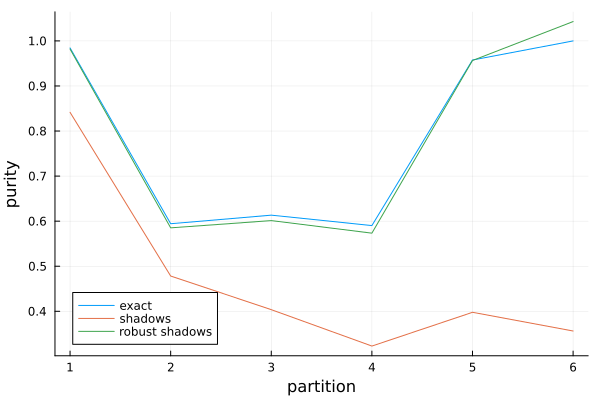

In [28]:
using Plots
plot(1:N,purity,label="exact")
plot!(1:N,purity_nonmit,label="shadows")
plot!(1:N,purity_mit,label="robust shadows")
xlabel!("partition")
ylabel!("purity")